In [1]:
import os
import random
import warnings
from datetime import datetime
import matplotlib.pyplot as plt
import pandas as pd
import scanpy as sc
import seaborn as sns
from matplotlib import gridspec
from sklearn.preprocessing import MinMaxScaler

from nichecompass.models import NicheCompass
from nichecompass.utils import (add_gps_from_gp_dict_to_adata,
                                compute_communication_gp_network,
                                visualize_communication_gp_network,
                                create_new_color_dict,
                                extract_gp_dict_from_mebocost_es_interactions,
                                extract_gp_dict_from_nichenet_lrt_interactions,
                                extract_gp_dict_from_omnipath_lr_interactions,
                                filter_and_combine_gp_dict_gps,
                                generate_enriched_gp_info_plots)

In [2]:
model = NicheCompass.load(dir_path='./',
                          adata=None,
                          adata_file_name="./mouse_organo_imputed.h5ad",
                          gp_names_key="nichecompass_gp_names")

/lustre/scratch126/cellgen/team361/am74/Adib/mambaforge/minicondaa/envs/nc/lib/python3.12/site-packages/anndata/__init__.py:55: FutureWarning: `anndata.read` is deprecated, use `anndata.read_h5ad` instead. `ad.read` will be removed in mid 2024.
  warnings.warn(


--- INITIALIZING NEW NETWORK MODULE: VARIATIONAL GENE PROGRAM GRAPH AUTOENCODER ---
LOSS -> include_edge_recon_loss: True, include_gene_expr_recon_loss: True, rna_recon_loss: nb
NODE LABEL METHOD -> one-hop-norm
ACTIVE GP THRESHOLD RATIO -> 0.01
LOG VARIATIONAL -> True
CATEGORICAL COVARIATES EMBEDDINGS INJECTION -> ['gene_expr_decoder']
ONE HOP GCN NORM RNA NODE LABEL AGGREGATOR
ENCODER -> n_input: 5000, n_cat_covariates_embed_input: 0, n_hidden: 1631, n_latent: 1531, n_addon_latent: 100, n_fc_layers: 1, n_layers: 1, conv_layer: gatv2conv, n_attention_heads: 4, dropout_rate: 0.0, 
COSINE SIM GRAPH DECODER -> dropout_rate: 0.0
MASKED TARGET RNA DECODER -> n_prior_gp_input: 1531, n_addon_gp_input: 100, n_cat_covariates_embed_input: 3, n_output: 5000
MASKED SOURCE RNA DECODER -> n_prior_gp_input: 1531, n_addon_gp_input: 100, n_cat_covariates_embed_input: 3, n_output: 5000


In [3]:
adata = model.adata.copy()

In [4]:
adata.X.max()

139.0

In [5]:
active_gps = model.get_active_gps()
print(f"Number of total gene programs: {len(model.adata.uns['nichecompass_gp_names'])}.")
print(f"Number of active gene programs: {len(active_gps)}.")

Number of total gene programs: 1631.
Number of active gene programs: 1108.


In [6]:
gp_summary_df = model.get_gp_summary()
gp_summary_df[gp_summary_df["gp_active"] == True].head()

,gp_name,all_gp_idx,gp_active,active_gp_idx,n_source_genes,n_non_zero_source_genes,n_target_genes,n_non_zero_target_genes,gp_source_genes,gp_target_genes,gp_source_genes_weights,gp_target_genes_weights,gp_source_genes_importances,gp_target_genes_importances
0,EPOR_ligand_receptor_GP,0,True,0,1,1,0,0,[Epor],[],[1.0829],[],[1.0],[]
1,TP53_ligand_receptor_GP,1,True,1,1,1,0,0,[Trp53],[],[-0.4539],[],[1.0],[]
2,NPPA_ligand_receptor_GP,2,True,2,1,1,1,1,[Nppa],[Prkg1],[-1.5607],[-1.1115],[0.5841],[0.4159]
3,CXCL12_ligand_receptor_GP,3,True,3,1,1,0,0,[Cxcl12],[],[-0.5384],[],[1.0],[]
4,PTPN11_ligand_receptor_GP,4,True,4,1,1,0,0,[Ptpn11],[],[0.0245],[],[1.0],[]


In [7]:
import numpy as np
len(np.unique(adata.obs['niche']))

20

In [8]:
gp_summary_df

,gp_name,all_gp_idx,gp_active,active_gp_idx,n_source_genes,n_non_zero_source_genes,n_target_genes,n_non_zero_target_genes,gp_source_genes,gp_target_genes,gp_source_genes_weights,gp_target_genes_weights,gp_source_genes_importances,gp_target_genes_importances
0,EPOR_ligand_receptor_GP,0,True,0,1,1,0,0,[Epor],[],[1.0829],[],[1.0],[]
1,TP53_ligand_receptor_GP,1,True,1,1,1,0,0,[Trp53],[],[-0.4539],[],[1.0],[]
2,NPPA_ligand_receptor_GP,2,True,2,1,1,1,1,[Nppa],[Prkg1],[-1.5607],[-1.1115],[0.5841],[0.4159]
3,CXCL12_ligand_receptor_GP,3,True,3,1,1,0,0,[Cxcl12],[],[-0.5384],[],[1.0],[]
4,PTPN11_ligand_receptor_GP,4,True,4,1,1,0,0,[Ptpn11],[],[0.0245],[],[1.0],[]
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1626,Add-on_95_GP,1626,True,1103,4306,4302,1658,1658,"[Perp, Barhl2, Rgcc, Mmp11, Klhl13, Tubb3, Dmr...","[Nkx1-2, Nkx2-6, Rgs5, Foxe1, Gm266, Bhlha9, X...","[-0.9641, 0.8777, -0.8646, -0.8067, 0.779, 0.6...","[0.9489, -0.9486, -0.8619, -0.8562, -0.8447, 0...","[0.002, 0.0018, 0.0018, 0.0017, 0.0016, 0.0014...","[0.002, 0.002, 0.0018, 0.0018, 0.0017, 0.0017,..."
1627,Add-on_96_GP,1627,True,1104,4306,4302,1658,1657,"[Barhl2, Foxd4, 1700019B21Rik, Fam13c, Serpinb...","[1700019B21Rik, Samd14, Nkx1-2, Doc2a, Bhlha9,...","[-0.7333, -0.6423, -0.6364, -0.6289, -0.5883, ...","[-0.6995, -0.6591, -0.6295, -0.5801, -0.5765, ...","[0.0011, 0.001, 0.0009, 0.0009, 0.0009, 0.0009...","[0.001, 0.001, 0.0009, 0.0009, 0.0009, 0.0008,..."
1628,Add-on_97_GP,1628,True,1105,4306,4300,1658,1657,"[Sh3kbp1, Pvalb, Enpp2, Shisa3, Kcna5, Tecrl, ...","[Gm21814, Rnd2, Raet1e, Msx3, Bhlha9, Wfdc21, ...","[-1.2267, -1.0097, 0.9197, -0.8924, -0.8712, -...","[-1.3466, -1.2204, -1.1193, -1.0973, -1.0963, ...","[0.002, 0.0016, 0.0015, 0.0015, 0.0014, 0.0014...","[0.0022, 0.002, 0.0018, 0.0018, 0.0018, 0.0017..."
1629,Add-on_98_GP,1629,True,1106,4306,4305,1658,1658,"[Qrfpr, Aqp11, Cldn10, Sp8, Apba2, A730017C20R...","[A730017C20Rik, Plppr3, Sox13, RMST_1, Rem2, A...","[-1.7301, -1.5567, -1.5411, -1.4433, -1.2193, ...","[-1.3816, -1.2238, -1.2154, -1.0988, -1.0729, ...","[0.0028, 0.0025, 0.0025, 0.0023, 0.002, 0.0018...","[0.0022, 0.002, 0.002, 0.0018, 0.0017, 0.0017,..."


In [9]:
adata.X.max(),adata.layers['counts'].max()

(139.0, 139.0)

In [10]:
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
adata.raw = adata  # freeze the state in `.raw`

In [11]:
sc.pp.highly_variable_genes(adata,subset=False,n_top_genes=2000)

In [12]:
sc.pp.pca(adata)

In [13]:
sc.pp.neighbors(adata,use_rep='X_pca')

In [14]:
sc.tl.umap(adata)

In [15]:
sc.set_figure_params(dpi=350)

In [16]:
import scanpy as sc
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score

resolutions = [0.1,0.15, 0.2,0.25, 0.3,0.35, 0.4,0.45, 0.5,0.55, 0.6,0.65, 0.7,0.75, 0.8,0.85, 0.9,0.95, 1,1.05,1.1,1.15,1.2,1.25,1.3,1.35,1.4,1.45,1.5,1.55,1.6,1.65,1.7,1.75,1.8,1.85,1.9,1.95,2]

silhouette_scores = []

for res in resolutions:
    sc.tl.leiden(adata, resolution=res, key_added=f'leiden_{res}')
    
    labels = adata.obs[f'leiden_{res}']
    silhouette_avg = silhouette_score(adata.obsm['X_pca'], labels, metric='euclidean')
    silhouette_scores.append(silhouette_avg)



/tmp/ipykernel_2848479/3726343368.py:11: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(adata, resolution=res, key_added=f'leiden_{res}')


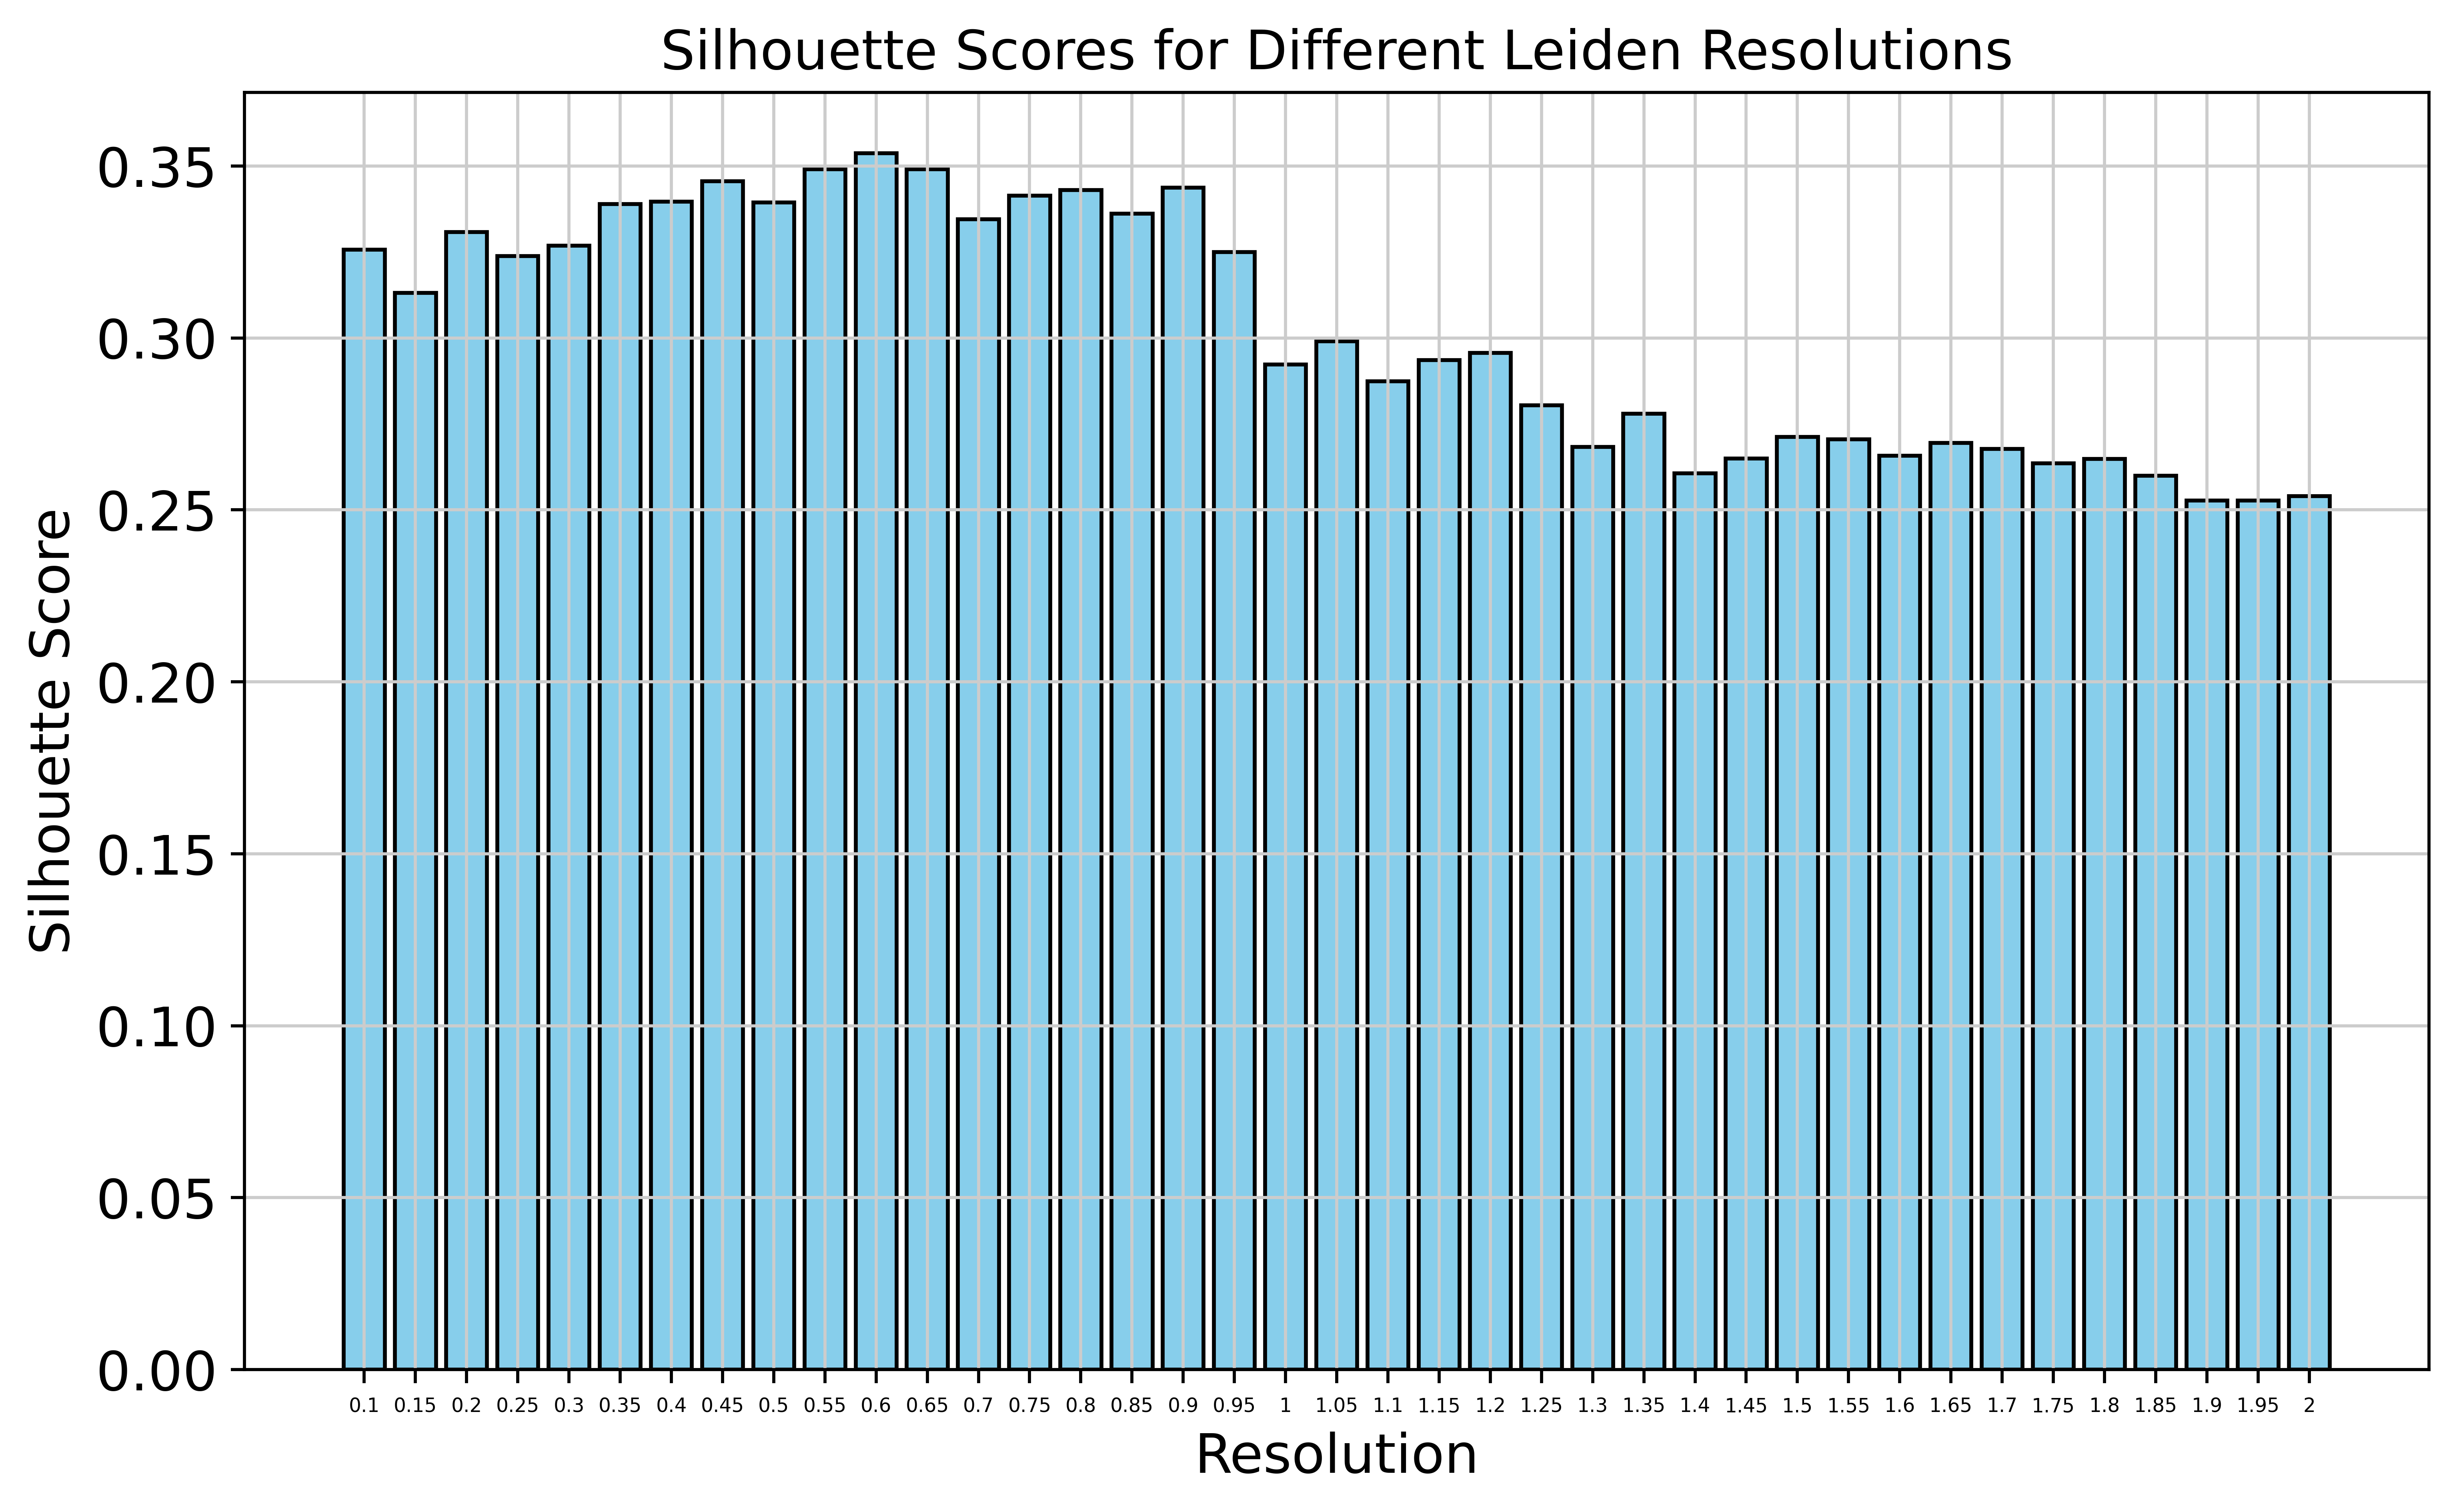

In [17]:
plt.figure(figsize=(10, 6))
plt.bar(range(len(resolutions)), silhouette_scores, color='skyblue', edgecolor='black')
plt.xticks(range(len(resolutions)), [str(r) for r in resolutions],fontsize=5)
plt.xlabel('Resolution')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Scores for Different Leiden Resolutions')
plt.show()

In [16]:
sc.tl.leiden(adata , resolution=0.6 ,key_added='leiden_0.6')

/tmp/ipykernel_248429/3683862348.py:1: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(adata , resolution=0.6 ,key_added='leiden_0.6')


In [17]:
adata.obs['leiden_0.6'] = adata.obs['leiden_0.6'].astype(str).apply(lambda x: f'c_{x}')

print(np.unique(adata.obs['leiden_0.6']))

['c_0' 'c_1' 'c_10' 'c_11' 'c_12' 'c_13' 'c_14' 'c_15' 'c_16' 'c_17'
 'c_18' 'c_19' 'c_2' 'c_20' 'c_21' 'c_22' 'c_23' 'c_24' 'c_3' 'c_4' 'c_5'
 'c_6' 'c_7' 'c_8' 'c_9']


In [18]:
import scanpy as sc
import pandas as pd

# Assuming 'adata' is your AnnData object
# Rank genes for each cluster against all other clusters
sc.tl.rank_genes_groups(adata, 'leiden_0.6', method='wilcoxon')

# Set to store the top genes from each cluster
top_genes_set = set()

# Iterate over each cluster to get the top 20 significant genes
for cluster in adata.obs['leiden_0.6'].cat.categories:
    # Extract the result for the current cluster
    cluster_genes = adata.uns['rank_genes_groups']['names'][cluster]
    cluster_pvals_adj = adata.uns['rank_genes_groups']['pvals_adj'][cluster]
    cluster_logfoldchanges = adata.uns['rank_genes_groups']['logfoldchanges'][cluster]

    # Combine the gene names, p-values, and log fold changes into a DataFrame
    cluster_df = pd.DataFrame({
        'gene': cluster_genes,
        'pval_adj': cluster_pvals_adj,
        'logfoldchange': cluster_logfoldchanges
    })

    # Filter for significant up-regulated genes (pval_adj < 0.05)
    significant_genes = cluster_df[(cluster_df['pval_adj'] < 0.05)]

    # Select the top 20 genes based on p-value
    top_genes = significant_genes.head(20)['gene']
    
    # Add the top genes to the set
    top_genes_set.update(top_genes)

# Convert the set to a list
aggregated_20_genes = list(top_genes_set)

# Print or return the aggregated list of top genes
print(aggregated_20_genes)


['Peg3', 'Ly6e', 'Ppil1', 'Alad', 'Kdr', 'Bbx', 'Ebf1', 'Sox2', 'Pdlim2', 'Arpc3', 'Acot1', 'Dusp12', 'Aldh7a1', 'Bud31', 'Ahnak', 'Nog', 'Sparcl1', 'Socs2', 'Msx1', 'Halr1', 'Naaa', 'Osr1', 'Irx3', 'Galk1', 'Slc9a3r1', 'Vamp5', 'Gngt2', 'Rab25', 'Ptprf', 'Arl4a', 'Ralb', 'Suv39h1', 'Myl1', 'Prr5', 'Ccnd1', 'Tfpi', 'Mfap2', 'Ppp1r14a', 'Cnn1', 'Tmem108', 'Smoc2', 'Tgfb2', 'Cdx4', 'Prkar2b', 'H2-Ke6', 'Pnpo', 'Zfp593', 'Basp1', 'Tubb3', 'Alas2', 'Tmem119', 'Tipin', 'Higd1a', 'Phgdh', 'Ptch1', 'Wnt2', 'Car14', 'Psip1', 'Timm50', 'Anxa2', 'Fbln1', 'Phb', 'Hhex', 'Paip2', 'Wfdc2', 'Espn', 'Nudc', 'Tpd52', 'Ecscr', 'Ube2e3', 'Gata6', 'Kif21a', 'Ldhb', 'Cdx2', 'Rrm2', 'Kti12', 'Frat2', 'Bola3', 'Tubb2b', 'Laptm4b', 'Mtx2', 'Cpm', 'Hoxb6', 'Arg1', 'Pcolce', 'Lysmd2', 'F11r', 'Rprm', 'Gm45123', 'Polr2f', 'Sap30', 'Ipo11', 'Ifitm2', 'Nop58', 'Pbx1', 'Phlda1', 'Lhx5', 'Ttn', 'Nkx2-9', 'Hoxd4', 'Foxf1', 'Morf4l2', 'Cldn6', 'Rgs5', 'Cdk1', 'Ramp2', 'Fkbp4', 'Tcf15', 'Psmb1', 'Ppp1r14c', 'Cthrc1', 

/lustre/scratch126/cellgen/team361/am74/Adib/mambaforge/minicondaa/envs/nc/lib/python3.12/site-packages/scanpy/tools/_rank_genes_groups.py:435: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, "names"] = self.var_names[global_indices]
/lustre/scratch126/cellgen/team361/am74/Adib/mambaforge/minicondaa/envs/nc/lib/python3.12/site-packages/scanpy/tools/_rank_genes_groups.py:437: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, "scores"] = scores[global_indices]
/lustre/scratch126/cellgen/team

In [19]:
import scanpy as sc
import pandas as pd

# Assuming 'adata' is your AnnData object
# Rank genes for each cluster against all other clusters
sc.tl.rank_genes_groups(adata, 'leiden_0.6', method='wilcoxon')

# Set to store the top genes from each cluster
top_genes_set = set()

# Iterate over each cluster to get the top 20 significant genes
for cluster in adata.obs['leiden_0.6'].cat.categories:
    # Extract the result for the current cluster
    cluster_genes = adata.uns['rank_genes_groups']['names'][cluster]
    cluster_pvals_adj = adata.uns['rank_genes_groups']['pvals_adj'][cluster]
    cluster_logfoldchanges = adata.uns['rank_genes_groups']['logfoldchanges'][cluster]

    # Combine the gene names, p-values, and log fold changes into a DataFrame
    cluster_df = pd.DataFrame({
        'gene': cluster_genes,
        'pval_adj': cluster_pvals_adj,
        'logfoldchange': cluster_logfoldchanges
    })

    # Filter for significant up-regulated genes (pval_adj < 0.05)
    significant_genes = cluster_df[(cluster_df['pval_adj'] < 0.05)]

    # Select the top 20 genes based on p-value
    top_genes = significant_genes.head(10)['gene']
    
    # Add the top genes to the set
    top_genes_set.update(top_genes)

# Convert the set to a list
aggregated_10_genes = list(top_genes_set)

# Print or return the aggregated list of top genes
print(aggregated_10_genes)


/lustre/scratch126/cellgen/team361/am74/Adib/mambaforge/minicondaa/envs/nc/lib/python3.12/site-packages/scanpy/tools/_rank_genes_groups.py:435: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, "names"] = self.var_names[global_indices]
/lustre/scratch126/cellgen/team361/am74/Adib/mambaforge/minicondaa/envs/nc/lib/python3.12/site-packages/scanpy/tools/_rank_genes_groups.py:437: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, "scores"] = scores[global_indices]
/lustre/scratch126/cellgen/team

['Idi1', 'Spint2', 'Cd81', 'Peg3', 'Ddt', 'Fgfbp3', 'Epcam', 'Car3', 'Aprt', 'Tmem88', 'Cdca7', 'Meox1', 'Hoxa7', 'H2afy2', 'Alad', 'Kdr', '1700011H14Rik', 'Bbx', 'Rgs10', 'Ebf1', 'Fgf15', 'Samd3', 'Gpx8', 'Sox2', 'F10', 'Hoxaas3', 'Arpc3', 'Acot1', 'Vstm2b', 'Pomp', 'Spin2c', 'Fermt3', 'Cd34', 'Slc39a8', 'Aldh7a1', 'Bud31', 'Fech', 'Pitx1', 'Slit2', 'Ahnak', 'Hoxb9', 'Hoxb2', 'Cdh5', 'Igf1', 'Slc38a4', 'Fam96a', 'Socs2', 'Fam181b', 'Msx1', 'Rnaset2a', 'Pdha1', 'Tceal8', 'Hpcal1', 'Osr1', 'Ptges3l', 'Galk1', 'Vamp5', 'Meis1', 'Gngt2', 'Epop', 'Pdgfa', 'Hoxb5os', 'Sfrp2', 'Rtn3', 'Gm2694', 'Ptprf', 'Ost4', 'Arl4a', 'Ralb', 'Pls3', 'Mkrn1', 'Cpox', 'Suv39h1', 'Smagp', 'Unc45b', 'Acer2', 'Myl1', 'Shh', 'Akr7a5', 'Eras', 'Prr7', 'Ccnd1', 'Plac1', 'Mfap2', 'Ubash3b', 'Fst', 'Cnn1', 'Tmem108', 'Lef1', 'Fabp5', 'Dek', 'Psme2', 'Lum', 'Cdx4', 'Twist2', 'Prkar2b', 'Cited1', 'Otx2', 'Kcnk1', 'Stard8', 'Zfp593', 'Lims1', 'Rnase4', 'Tubb3', 'Hnrnph3', 'Alas2', 'Oaf', 'Tipin', 'Limd2', 'Foxc2', 'Rb

In [20]:
list(np.unique(adata.obs['niche']))

['Bmp4 GP/Vegfb GP+ Lateral Plate Mesoderm',
 'Bmp8a GP/9-cis-Ret. acid GP+ Splanchnic Mesoderm',
 'Calca GP/Shh GP+ Floor Plate',
 'Cdh13 GP/Col1a1 GP+ Mixed mesenchymal mesoderm',
 'Cthrc1 GP/Pdgfc GP+ Dorsal Gut',
 'Edn1 GP/Nppa1 GP+ Developing Heart',
 'Epo GP/Thpo GP+ Vasculature (Hematopoiesis)',
 'Fgf17 GP/Efna2 GP+ Midbrain',
 'Fgf18 GP/Dll1 GP+ Presomitic Mesoderm',
 'Gdf10 GP/Fgf3 GP+ Hindbrain',
 'Guanine GP/Slitrk1 GP+ Neural Crest (Neural Tube)',
 'IL10 GP/Fgf2 GP+ Vasculature (Angiogenesis)',
 'Ihh GP/Spint1 GP+ Ventral Gut',
 'Mix',
 'Nptn GP/Fgf8 GP+ Spinal cord',
 'Pcsk1n GP/Dkk1 GP+ Forebrain',
 'Pgf GP/Cd44 GP+ Allantois',
 'Saa1 GP/Il6st GP+ Muscles',
 'Sfrp4 GP/Pdgfa GP+ Surface Ectoderm',
 'Tgfbi GP/Fgf6 GP+ Cranial Mesoderm']

In [21]:
# Set parameters for differential gp testing
selected_cats = None
comparison_cats = "rest"
title = f"NicheCompass Strongly Enriched Niche GPs"
log_bayes_factor_thresh = 2.3


In [22]:
# Run differential gp testing
enriched_gps = model.run_differential_gp_tests(
    cat_key='niche',
    selected_cats=selected_cats,
    comparison_cats=comparison_cats,
    log_bayes_factor_thresh=log_bayes_factor_thresh)

/lustre/scratch126/cellgen/team361/am74/Adib/mambaforge/minicondaa/envs/nc/lib/python3.12/site-packages/nichecompass/data/utils.py:71: UserWarning: torch.sparse.SparseTensor(indices, values, shape, *, device=) is deprecated.  Please use torch.sparse_coo_tensor(indices, values, shape, dtype=, device=). (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:621.)
  torch_sparse_coo_tensor = torch.sparse.FloatTensor(indices, values, shape)
/lustre/scratch126/cellgen/team361/am74/Adib/mambaforge/minicondaa/envs/nc/lib/python3.12/site-packages/torch_geometric/sampler/neighbor_sampler.py:55: UserWarning: The usage of the 'directed' argument in 'NeighborSampler' is deprecated. Use `subgraph_type='induced'` instead.
  warnings.warn(f"The usage of the 'directed' argument in "


In [24]:
adata

AnnData object with n_obs × n_vars = 52568 × 5000
    obs: 'Area', 'celltype_mapped_refined', 'sample', 'batch', 'mapping_entity', 'EPOR_ligand_receptor_GP', 'TP53_ligand_receptor_GP', 'NPPA_ligand_receptor_GP', 'CXCL12_ligand_receptor_GP', 'PTPN11_ligand_receptor_GP', 'EFNB3_ligand_receptor_GP', 'EFNB1_ligand_receptor_GP', 'S100A1_ligand_receptor_GP', 'GSTO1_ligand_receptor_GP', 'CCL27_ligand_receptor_GP', 'MT-RNR2_ligand_receptor_GP', 'SAA1_ligand_receptor_GP', 'PYY_ligand_receptor_GP', 'NOTCH1_ligand_receptor_GP', 'KITLG_ligand_receptor_GP', 'NRG1_ligand_receptor_GP', 'PRL_ligand_receptor_GP', 'LRIG1_ligand_receptor_GP', 'PDGFC_ligand_receptor_GP', 'PDGFA_ligand_receptor_GP', 'FGF2_ligand_receptor_GP', 'FGF8_ligand_receptor_GP', 'VEGFB_ligand_receptor_GP', 'FGF6_ligand_receptor_GP', 'VCAN_ligand_receptor_GP', 'CEACAM6_ligand_receptor_GP', 'ARF4_ligand_receptor_GP', 'ANG_ligand_receptor_GP', 'IGF2_ligand_receptor_GP', 'SOCS2_ligand_receptor_GP', 'KDR_ligand_receptor_GP', 'FSTL1_ligan

In [30]:
# Results are stored in a df in the adata object
df=model.adata.uns['nichecompass_differential_gp_test_results']

In [31]:
df

,category,gene_program,p_h0,p_h1,log_bayes_factor
0,Epo GP/Thpo GP+ Vasculature (Hematopoiesis),Scgb3a1_ligand_receptor_target_gene_GP,1.000000e+00,0.000000,27.631021
1,Epo GP/Thpo GP+ Vasculature (Hematopoiesis),Apod_ligand_receptor_target_gene_GP,0.000000e+00,1.000000,-27.631021
2,Epo GP/Thpo GP+ Vasculature (Hematopoiesis),Col16a1_ligand_receptor_target_gene_GP,1.000000e+00,0.000000,27.631021
3,Epo GP/Thpo GP+ Vasculature (Hematopoiesis),Ntf5_ligand_receptor_target_gene_GP,8.754876e-65,1.000000,-27.631021
4,Epo GP/Thpo GP+ Vasculature (Hematopoiesis),Il22_ligand_receptor_target_gene_GP,1.000000e+00,0.000000,27.631021
...,...,...,...,...,...
2930,Calca GP/Shh GP+ Floor Plate,Tspan33_ligand_receptor_target_gene_GP,9.097747e-02,0.909023,-2.301758
2931,Nptn GP/Fgf8 GP+ Spinal cord,Mfap3l_ligand_receptor_target_gene_GP,9.099780e-02,0.909002,-2.301512
2932,Calca GP/Shh GP+ Floor Plate,Add-on_7_GP,9.089807e-01,0.091019,2.301252
2933,Edn1 GP/Nppa1 GP+ Developing Heart,Scgb3a1_ligand_receptor_target_gene_GP,9.089503e-01,0.091050,2.300885


In [32]:
list(np.unique(df['gene_program']))

['11-cis-Retinol_metabolite_enzyme_sensor_GP',
 '2-Hydroxyestradiol_metabolite_enzyme_sensor_GP',
 '2300002M23Rik_ligand_receptor_target_gene_GP',
 '2610528A11Rik_ligand_receptor_target_gene_GP',
 '3-Methoxytyramine_metabolite_enzyme_sensor_GP',
 '5-Aminolevulinic_acid_metabolite_enzyme_sensor_GP',
 '5-Methyltetrahydrofolic_acid_metabolite_enzyme_sensor_GP',
 '9-cis-Retinoic_acid_metabolite_enzyme_sensor_GP',
 'ACTR2_ligand_receptor_GP',
 'ADO_ligand_receptor_GP',
 'ADP_metabolite_enzyme_sensor_GP',
 'AFDN_ligand_receptor_GP',
 'AGTRAP_ligand_receptor_GP',
 'AMELY_ligand_receptor_GP',
 'ANGPT1_ligand_receptor_GP',
 'ANGPTL5_ligand_receptor_GP',
 'ANG_ligand_receptor_GP',
 'ANOS1_ligand_receptor_GP',
 'APELA_ligand_receptor_GP',
 'ARF4_ligand_receptor_GP',
 'ARF6_ligand_receptor_GP',
 'ARPC5_ligand_receptor_GP',
 'Abca1_ligand_receptor_target_gene_GP',
 'Ace2_ligand_receptor_target_gene_GP',
 'Ace_ligand_receptor_target_gene_GP',
 'Acp4_ligand_receptor_target_gene_GP',
 'Adam10_ligand_r

In [33]:
gp_list_without_add_gps = df[~df['gene_program'].str.startswith('Add-')]

# Display the filtered DataFrame
print(gp_list_without_add_gps)

                                         category  \
0     Epo GP/Thpo GP+ Vasculature (Hematopoiesis)   
1     Epo GP/Thpo GP+ Vasculature (Hematopoiesis)   
2     Epo GP/Thpo GP+ Vasculature (Hematopoiesis)   
3     Epo GP/Thpo GP+ Vasculature (Hematopoiesis)   
4     Epo GP/Thpo GP+ Vasculature (Hematopoiesis)   
...                                           ...   
2929                    Pgf GP/Cd44 GP+ Allantois   
2930                 Calca GP/Shh GP+ Floor Plate   
2931                 Nptn GP/Fgf8 GP+ Spinal cord   
2933           Edn1 GP/Nppa1 GP+ Developing Heart   
2934                Ihh GP/Spint1 GP+ Ventral Gut   

                                gene_program          p_h0      p_h1  \
0     Scgb3a1_ligand_receptor_target_gene_GP  1.000000e+00  0.000000   
1        Apod_ligand_receptor_target_gene_GP  0.000000e+00  1.000000   
2     Col16a1_ligand_receptor_target_gene_GP  1.000000e+00  0.000000   
3        Ntf5_ligand_receptor_target_gene_GP  8.754876e-65  1.000000   
4  

In [36]:
all_sig_gps=list(np.unique(gp_list_without_add_gps['gene_program']))

In [38]:
# List of target gene programs
target_gps = all_sig_gps

# Filter the dataframe for the specified GPs
filtered_df = gp_summary_df[gp_summary_df['gp_name'].isin(target_gps)]

# Function to filter genes based on importance
def filter_genes_by_importance(genes, importances, threshold=0.05):
    return [gene for gene, importance in zip(genes, importances) if importance > threshold]

# Apply filtering function to source and target genes
filtered_df['filtered_source_genes'] = filtered_df.apply(lambda row: filter_genes_by_importance(row['gp_source_genes'], row['gp_source_genes_importances']), axis=1)
filtered_df['filtered_target_genes'] = filtered_df.apply(lambda row: filter_genes_by_importance(row['gp_target_genes'], row['gp_target_genes_importances']), axis=1)

# Combine the filtered source and target genes into a single list
filtered_df['total_genes'] = filtered_df.apply(lambda row: row['filtered_source_genes'] + row['filtered_target_genes'], axis=1)

# Aggregate all genes from the filtered GPs
high_importance_genes = set(gene for genes in filtered_df['total_genes'] for gene in genes)

print(high_importance_genes)

{'H2-D1', 'Glb1', 'Fgfbp1', 'Bnip3', 'Ebf1', 'En1', 'Pim2', 'Sox2', 'Tbx1', 'Plekha7', 'Acot1', 'Trp63', 'Ece1', 'Tom1', 'Il10rb', 'Ahnak', 'Acat1', 'Ptbp2', 'Nog', 'Mylpf', 'Ezr', 'Afp', 'Qrfpr', 'Slc43a1', 'Aqp3', 'Vgll3', 'Msx1', 'Ppp1r18', 'Fgfr2', 'Irx3', 'Kcns3', 'Tpd52l1', 'Upp1', 'Cldn3', 'P2rx4', 'Hspb8', 'Col1a1', 'Notum', 'Ptpre', 'Tfpi', 'Prkca', 'Mfap2', 'Lmod3', 'Gimap1', 'Cnn1', 'Apoa5', 'Evx1', 'Cox20', 'Vcan', 'Tnfaip6', 'Gata1', 'Id4', 'Myo10', 'Cdc42ep4', 'Kcng2', 'Ptch1', 'Rspo1', 'Wnt2', 'Ctnnd1', 'Sfrp5', 'Psip1', 'Nfs1', 'Capg', 'Cirbp', 'Slc38a5', 'Spns2', 'Serpinb6a', 'Anxa2', 'Wfdc2', 'Mafb', 'Tnni2', 'Mdh2', 'Svep1', 'Wscd1', 'Ldhb', 'Grina', 'Glipr2', 'Frat2', 'Dhx40', 'Akr1a1', 'Cpm', 'Smox', 'Bst2', 'Angpt1', 'Cbfa2t3', 'Cldn4', 'Npr1', 'Cd59a', 'Rhoj', 'Flt1', 'Cdc42ep1', 'Vash2', 'Ahsa1', 'Ank1', 'Gpbp1', 'Idh1', 'Cdh11', 'Qprt', 'Mt1', 'Galnt1', 'Ramp2', 'Tbx18', 'Tfap2a', 'Tln1', 'Tcf7l2', 'Myoz1', 'Ak6', 'Plvap', 'Sapcd2', 'Jup', 'Cd93', 'Plekha5', 'I

/tmp/ipykernel_248429/1423051428.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['filtered_source_genes'] = filtered_df.apply(lambda row: filter_genes_by_importance(row['gp_source_genes'], row['gp_source_genes_importances']), axis=1)
/tmp/ipykernel_248429/1423051428.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['filtered_target_genes'] = filtered_df.apply(lambda row: filter_genes_by_importance(row['gp_target_genes'], row['gp_target_genes_importances']), axis=1)
/tmp/ipyke

In [73]:
set1 = set(high_importance_genes)
set2 = set(aggregated_20_genes)

intersection = set1.intersection(set2)

print("Intersection:", intersection)

Intersection: {'Vamp5', 'Fgfbp3', 'Aprt', 'Pdgfa', 'Pcsk1n', 'Kdr', 'Smagp', 'Aldh1a2', 'Fgf3', 'Wnt6', 'Nkx2-9', 'Plp1', 'Icam2', 'Adgrg1', 'Col9a1', 'Cldn7', 'Sox10', 'Cthrc1', 'Aldoc'}


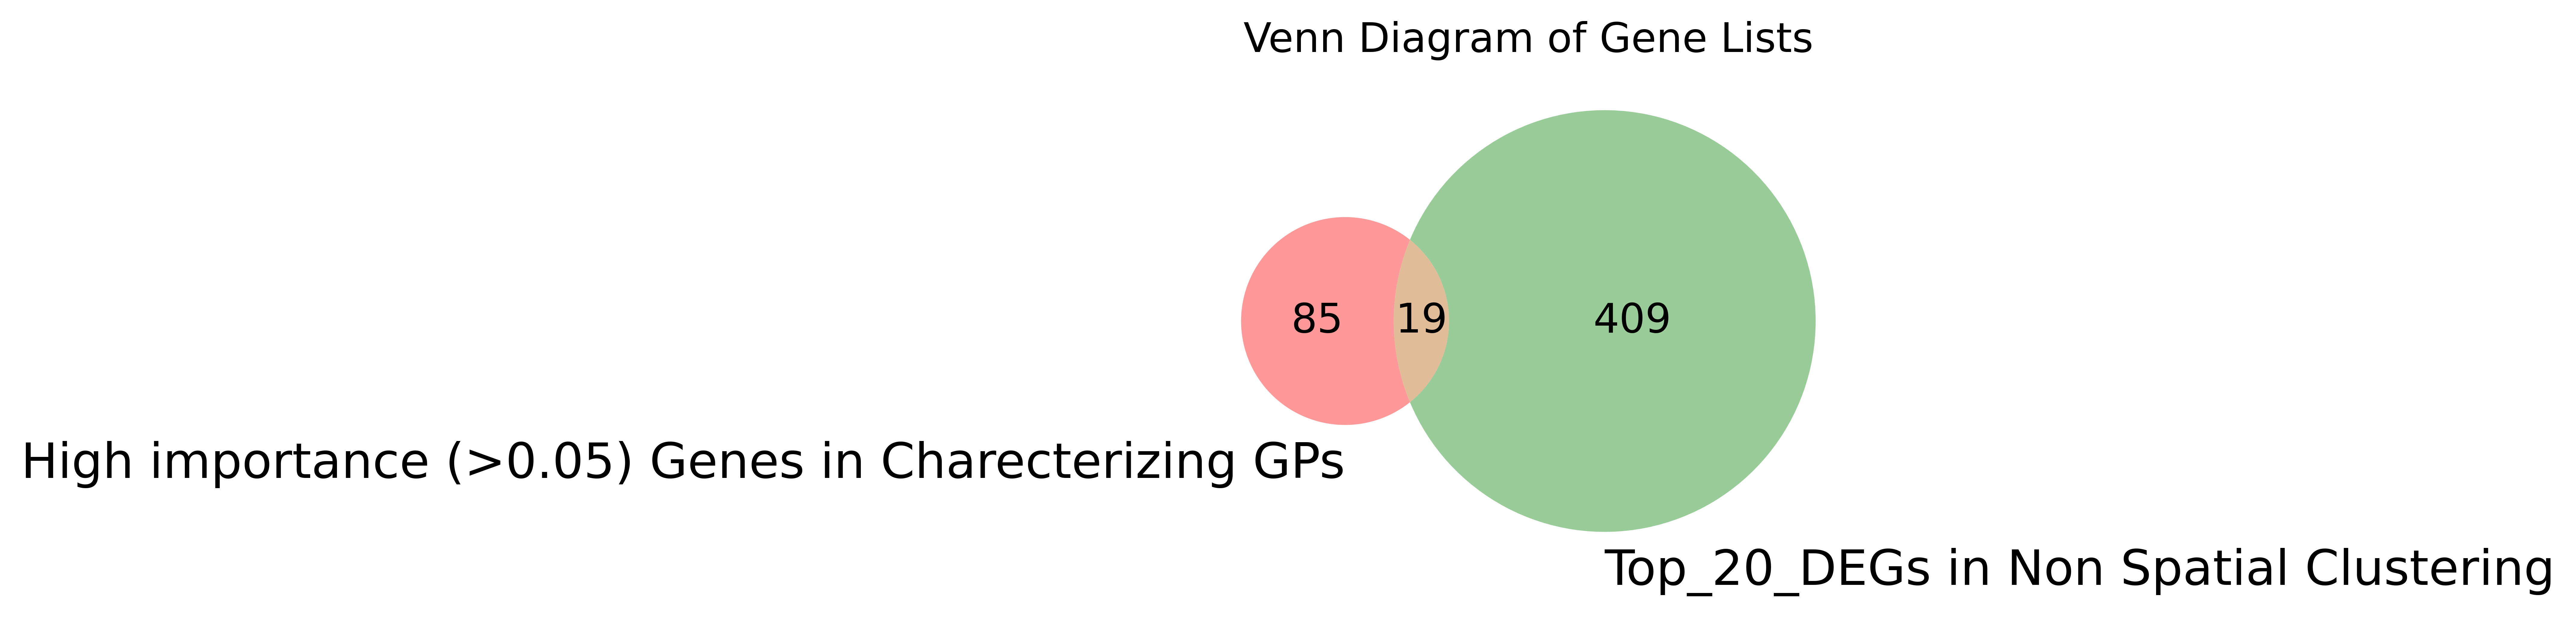

In [74]:
import matplotlib.pyplot as plt
from matplotlib_venn import venn2
venn2([set1, set2], ('High importance (>0.05) Genes in All Strong GPs', 'Top_20_DEGs in Non Spatial Clustering'))

plt.title('Venn Diagram of Gene Lists')
# plt.show()
plt.savefig('./overlap_20_degs_importance.svg', format='svg', bbox_inches='tight')

In [41]:
set4 = set(aggregated_10_genes)


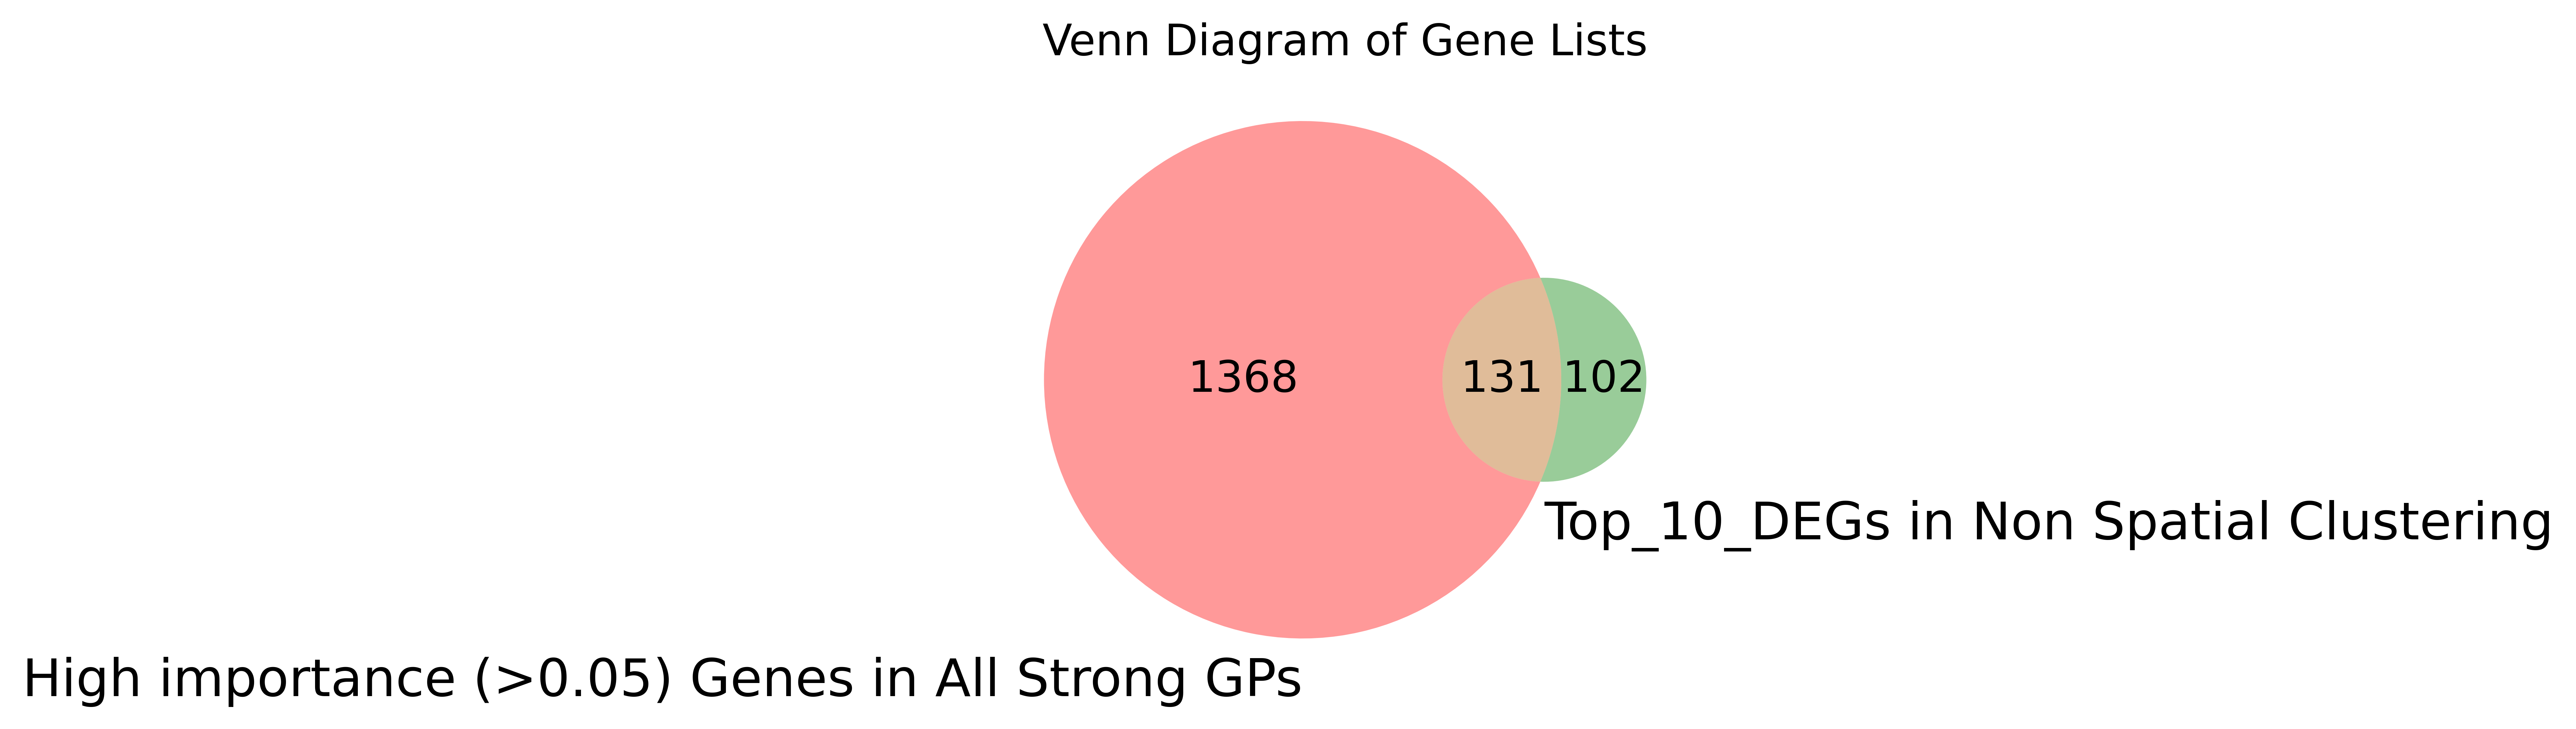

In [42]:
import matplotlib.pyplot as plt
from matplotlib_venn import venn2
venn2([set1, set4], ('High importance (>0.05) Genes in All Strong GPs', 'Top_10_DEGs in Non Spatial Clustering'))

plt.title('Venn Diagram of Gene Lists')
# plt.show()
plt.savefig('./overlap_10_degs_importance.svg', format='svg', bbox_inches='tight')

In [43]:
import numpy as np

# Assuming 'adata' is your AnnData object
all_genes = list(adata.var_names)  # List of all genes in adata.var_names


# Intersection of set1 and set2
set_intersection = set1.intersection(set2)

# Number of random selections and number of genes to select each time
n_selections = 10
n_genes_to_select = 428

# Lists to store the overlap results
overlap_set1 = []
overlap_set2 = []
overlap_intersection = []

# Perform the random selections and calculate overlaps
for _ in range(n_selections):
    # Randomly select 422 genes
    random_genes = set(np.random.choice(all_genes, n_genes_to_select, replace=False))
    
    # Calculate the intersection with set1, set2, and the intersection of set1 and set2
    overlap_with_set1 = len(random_genes.intersection(set1))
    overlap_with_set2 = len(random_genes.intersection(set2))
    overlap_with_intersection = len(random_genes.intersection(set_intersection))
    
    # Store the results
    overlap_set1.append(overlap_with_set1)
    overlap_set2.append(overlap_with_set2)
    overlap_intersection.append(overlap_with_intersection)

# Calculate the mean overlap for set1, set2, and their intersection
mean_overlap_set1 = np.mean(overlap_set1)
mean_overlap_set2 = np.mean(overlap_set2)
mean_overlap_intersection = np.mean(overlap_intersection)

# Print the mean overlaps
print(f"Mean overlap with set1: {mean_overlap_set1}")
print(f"Mean overlap with set2: {mean_overlap_set2}")
print(f"Mean overlap with the intersection of set1 and set2: {mean_overlap_intersection}")

Mean overlap with set1: 129.4
Mean overlap with set2: 38.3
Mean overlap with the intersection of set1 and set2: 20.1


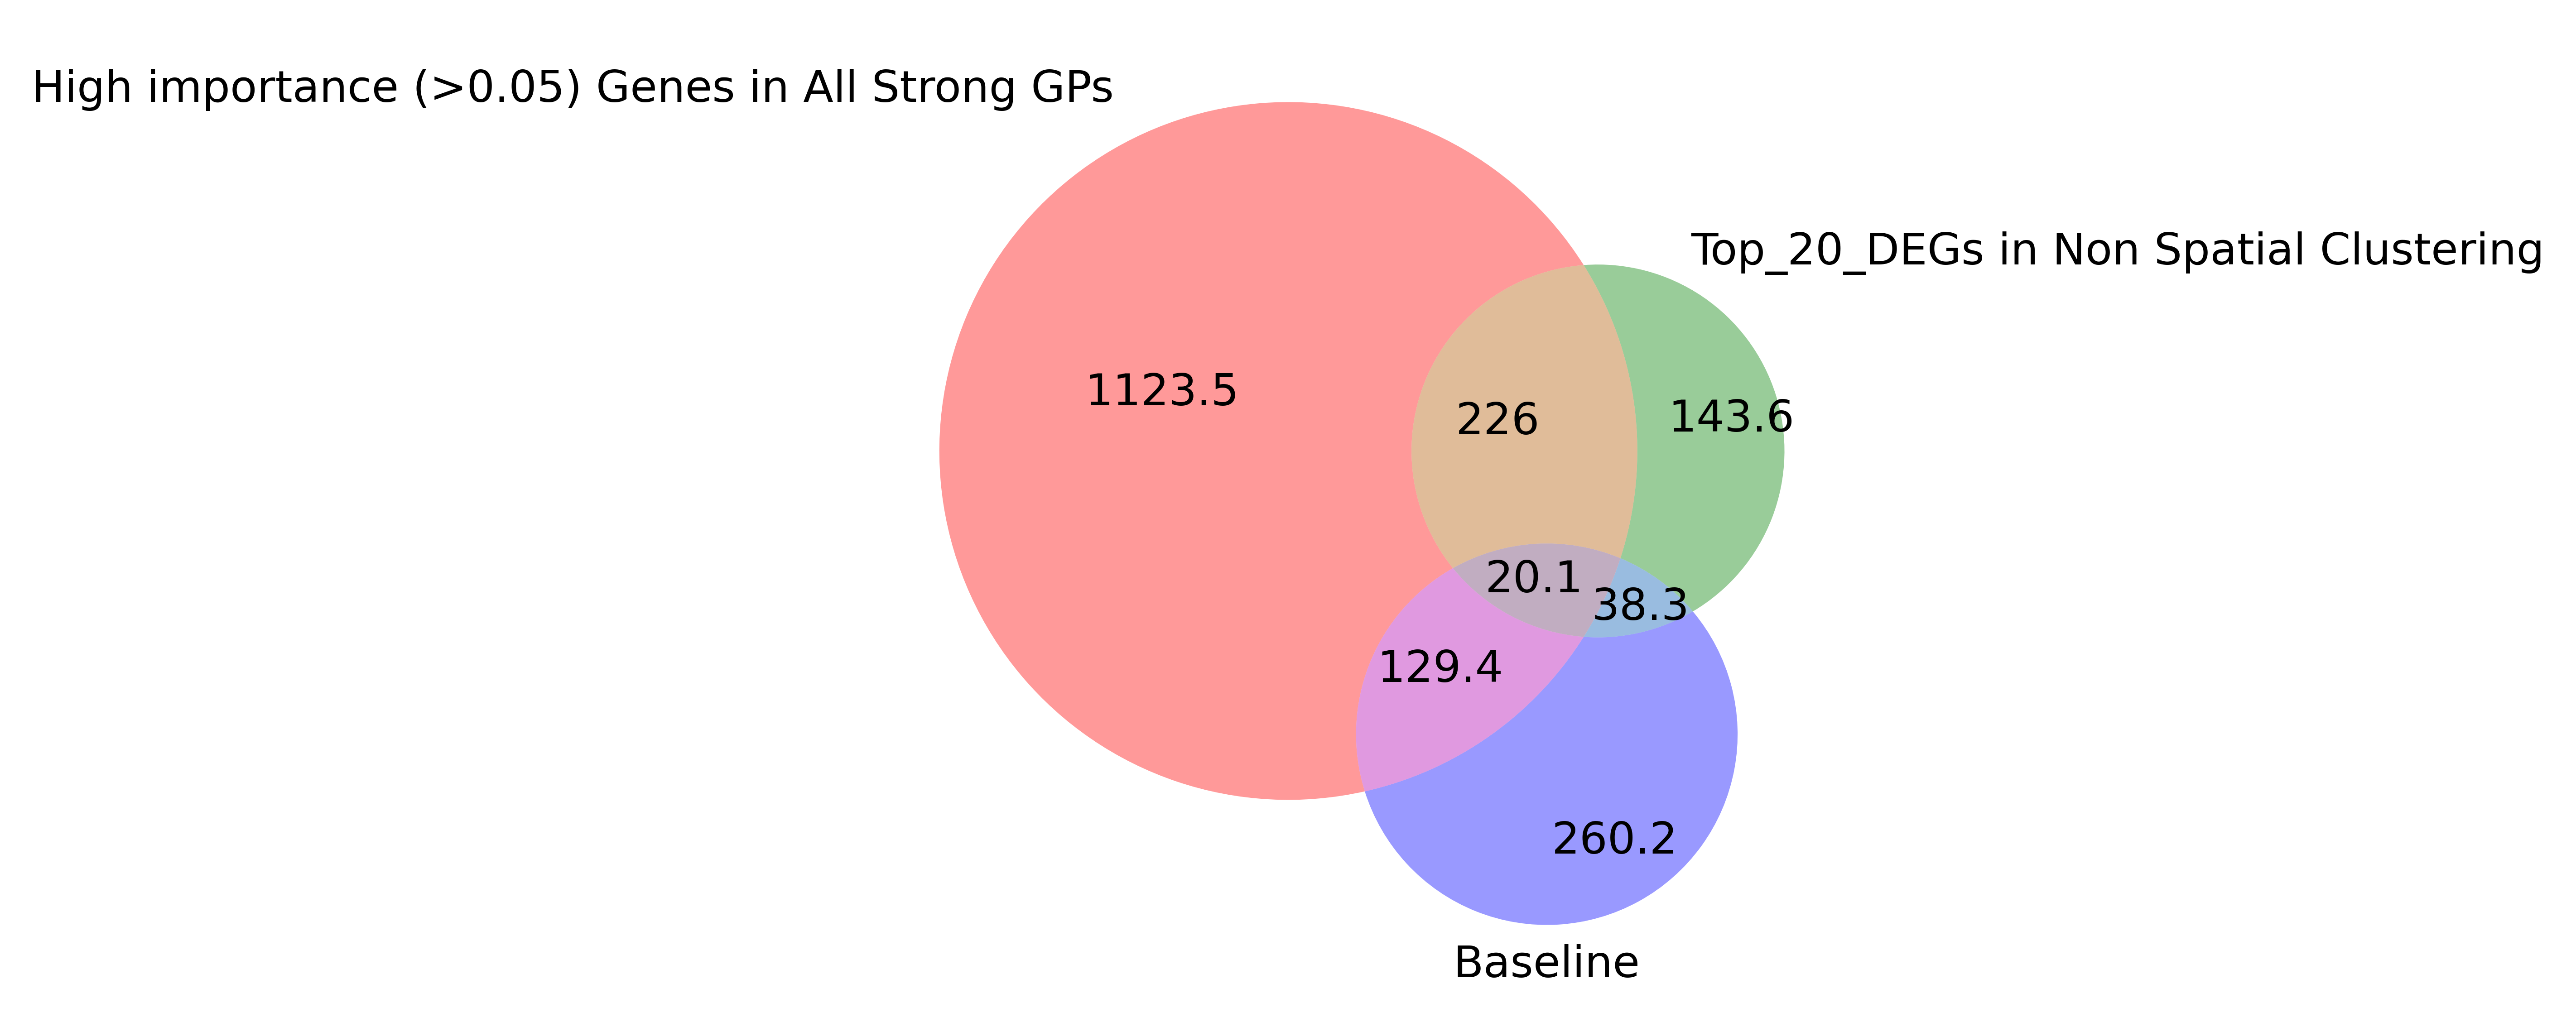

In [56]:
import matplotlib.pyplot as plt
from matplotlib_venn import venn3
from matplotlib import font_manager

# Set sizes
len_set1 = 1123.5
len_set2 = 143.6
len_set3 = 260.2

# Overlaps
overlap_14 = 226    # Overlap between set1 and set2
overlap_13 = 129.4  # Overlap between set1 and set3
overlap_23 = 38.3  # Overlap between set2 and set3
overlap_123 = 20.1  # Overlap between all three sets

# Create the Venn diagram
venn=venn3(subsets=(len_set1, len_set2, overlap_14, len_set3, overlap_13, overlap_23, overlap_123),
      set_labels=('High importance (>0.05) Genes in All Strong GPs', 'Top_20_DEGs in Non Spatial Clustering', 'Baseline'))

# Adjust font properties for labels
font_properties = font_manager.FontProperties(size=10)  # Adjust size as needed

# Apply font properties to set labels
for label in venn.set_labels:
    label.set_fontproperties(font_properties)

# Apply font properties to subset labels
for label in venn.subset_labels:
    label.set_fontproperties(font_properties)

# Display the plot
# plt.show()
plt.savefig('./overlap_20_degs_baselines_importance_all_gps.svg', format='svg', bbox_inches='tight')

In [66]:
import numpy as np

# Assuming 'adata' is your AnnData object
all_genes = list(adata.var_names)  # List of all genes in adata.var_names


# Intersection of set1 and set2
set_intersection = set1.intersection(set2)

# Number of random selections and number of genes to select each time
n_selections = 10
n_genes_to_select = 233

# Lists to store the overlap results
overlap_set1 = []
overlap_set4 = []
overlap_intersection = []

# Perform the random selections and calculate overlaps
for _ in range(n_selections):
    # Randomly select 422 genes
    random_genes = set(np.random.choice(all_genes, n_genes_to_select, replace=False))
    
    # Calculate the intersection with set1, set2, and the intersection of set1 and set2
    overlap_with_set1 = len(random_genes.intersection(set1))
    overlap_with_set4 = len(random_genes.intersection(set4))
    overlap_with_intersection = len(random_genes.intersection(set_intersection))
    
    # Store the results
    overlap_set1.append(overlap_with_set1)
    overlap_set4.append(overlap_with_set4)
    overlap_intersection.append(overlap_with_intersection)

# Calculate the mean overlap for set1, set2, and their intersection
mean_overlap_set1 = np.mean(overlap_set1)
mean_overlap_set4 = np.mean(overlap_set4)
mean_overlap_intersection = np.mean(overlap_intersection)

# Print the mean overlaps
print(f"Mean overlap with set1: {mean_overlap_set1}")
print(f"Mean overlap with set4: {mean_overlap_set4}")
print(f"Mean overlap with the intersection of set1 and set4: {mean_overlap_intersection}")

Mean overlap with set1: 71.2
Mean overlap with set4: 9.7
Mean overlap with the intersection of set1 and set4: 10.6


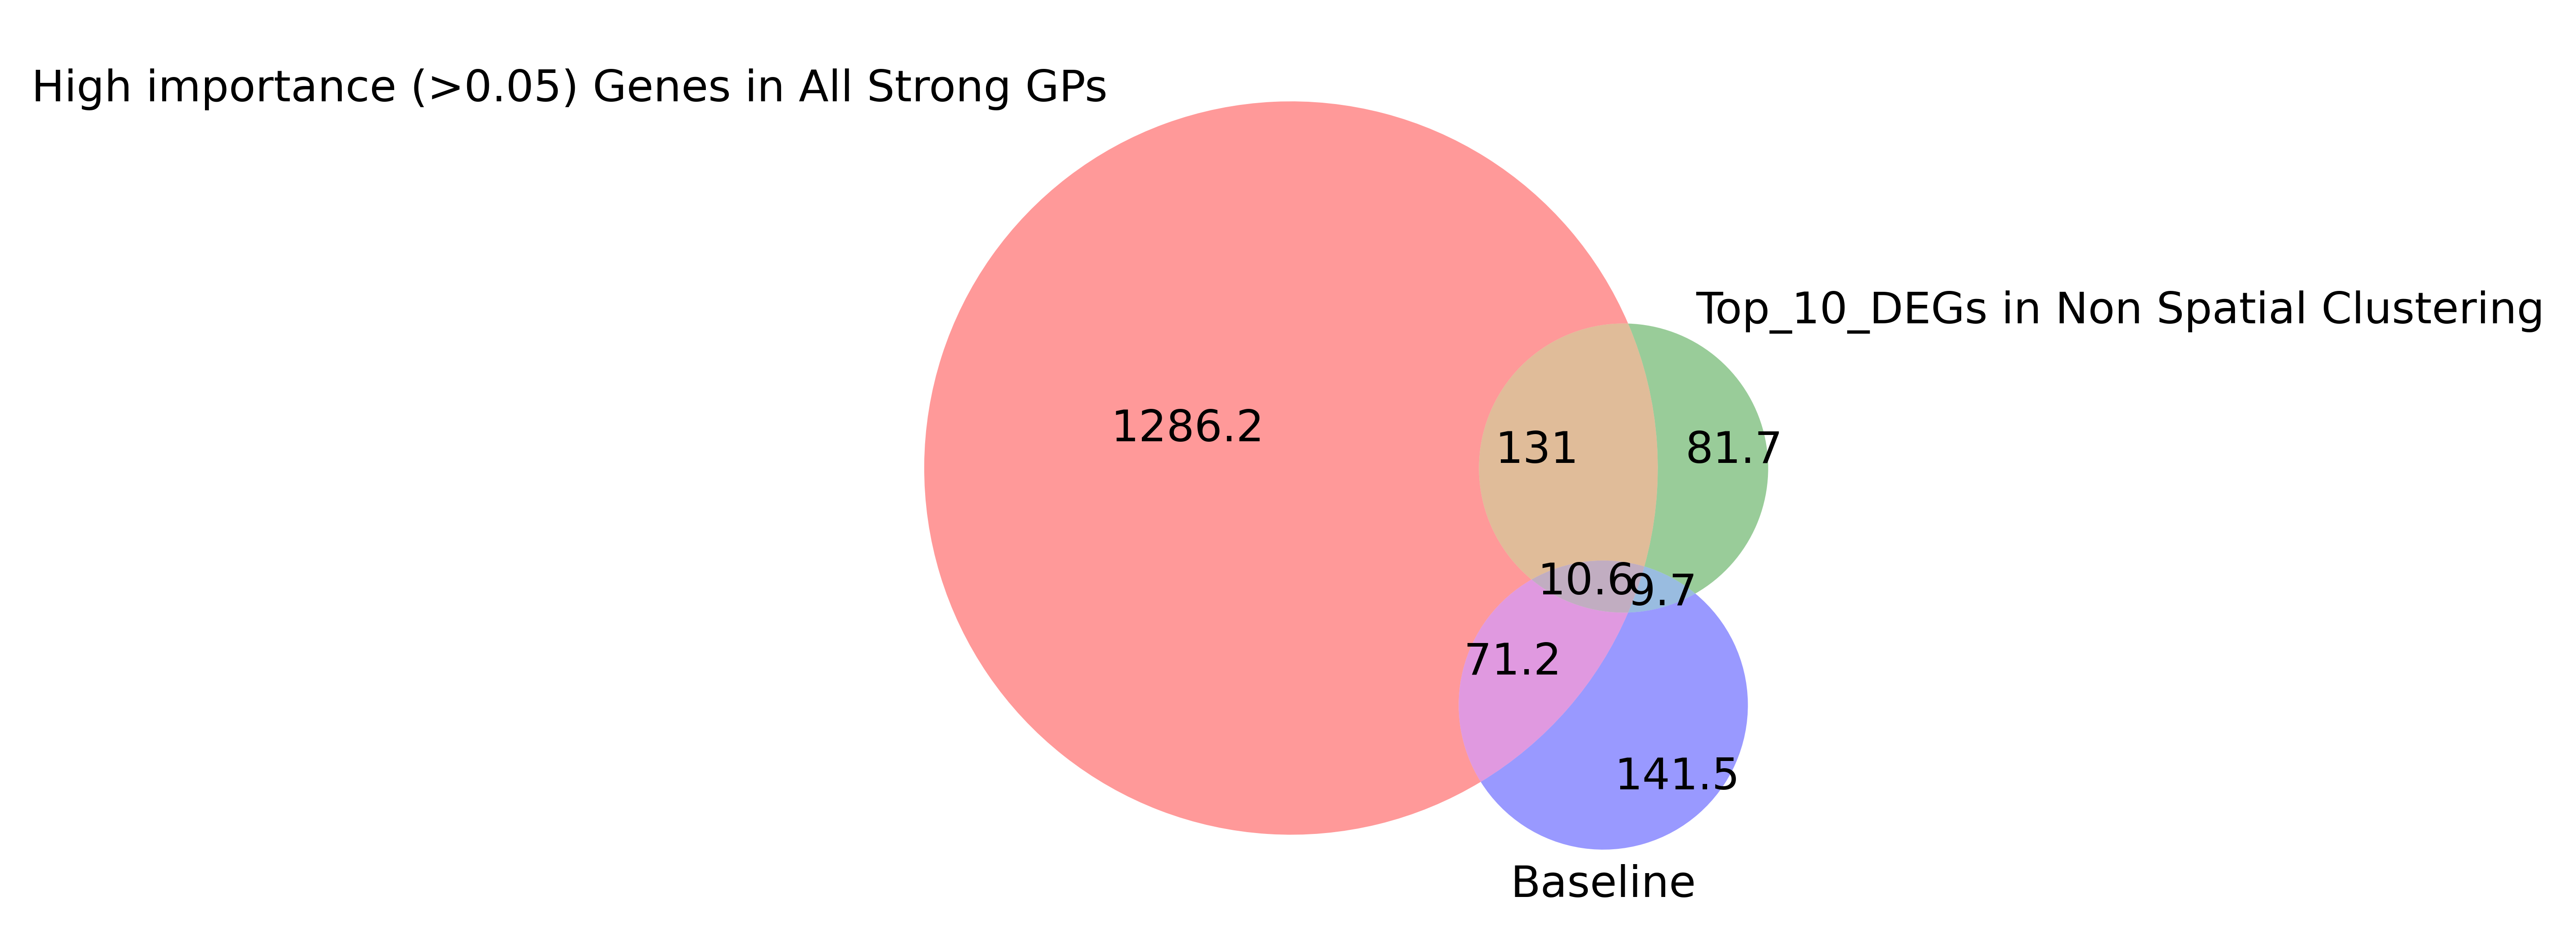

In [70]:
import matplotlib.pyplot as plt
from matplotlib_venn import venn3
from matplotlib import font_manager

# Set sizes
len_set1 = 1286.2
len_set4 = 81.7
len_set3 = 141.5

# Overlaps
overlap_14 = 131    # Overlap between set1 and set2
overlap_13 = 71.2  # Overlap between set1 and set3
overlap_43 = 9.7  # Overlap between set2 and set3
overlap_143 = 10.6  # Overlap between all three sets

# Create the Venn diagram
venn=venn3(subsets=(len_set1, len_set4, overlap_14, len_set3, overlap_13, overlap_43, overlap_143),
      set_labels=('High importance (>0.05) Genes in All Strong GPs', 'Top_10_DEGs in Non Spatial Clustering', 'Baseline'))

# Adjust font properties for labels
font_properties = font_manager.FontProperties(size=10)  # Adjust size as needed

# Apply font properties to set labels
for label in venn.set_labels:
    label.set_fontproperties(font_properties)

# Apply font properties to subset labels
for label in venn.subset_labels:
    label.set_fontproperties(font_properties)

# Display the plot
# plt.show()
plt.savefig('./overlap_10_degs_baselines_importance_all_gps.svg', format='svg', bbox_inches='tight')

In [ ]:
## For charecteristic Gps

In [71]:
# List of target gene programs
target_gps = [
    'Cdh13_ligand_receptor_target_gene_GP', 'Col1a1_ligand_receptor_target_gene_GP',
    'Bmp4_ligand_receptor_target_gene_GP', 'Vegfb_ligand_receptor_target_gene_GP',
    'Pgf_ligand_receptor_target_gene_GP', 'Cd44_ligand_receptor_target_gene_GP',
    'Bmp8a_ligand_receptor_target_gene_GP', '9-cis-Retinoic_acid_metabolite_enzyme_sensor_GP',
    'Edn1_ligand_receptor_target_gene_GP', 'NPPA_ligand_receptor_GP',
    'Cthrc1_ligand_receptor_target_gene_GP', 'Pdgfc_ligand_receptor_target_gene_GP',
    'Ihh_ligand_receptor_target_gene_GP', 'Spint1_ligand_receptor_target_gene_GP',
    'SFRP4_ligand_receptor_GP', 'PDGFA_ligand_receptor_GP',
    'Guanine_metabolite_enzyme_sensor_GP', 'Slitrk1_ligand_receptor_target_gene_GP',
    'Tgfbi_ligand_receptor_target_gene_GP', 'FGF6_ligand_receptor_GP',
    'Epo_ligand_receptor_target_gene_GP', 'Thpo_ligand_receptor_target_gene_GP',
    'Il10_ligand_receptor_target_gene_GP', 'Fgf2_ligand_receptor_target_gene_GP',
    'Fgf17_ligand_receptor_target_gene_GP', 'Efna2_ligand_receptor_target_gene_GP',
    'PCSK1N_ligand_receptor_GP', 'DKK1_ligand_receptor_GP',
    'Calca_ligand_receptor_target_gene_GP', 'Shh_ligand_receptor_target_gene_GP',
    'Gdf10_ligand_receptor_target_gene_GP', 'Fgf3_ligand_receptor_target_gene_GP',
    'NPTN_ligand_receptor_GP', 'Fgf8_ligand_receptor_target_gene_GP',
    'SAA1_ligand_receptor_GP', 'IL6ST_ligand_receptor_GP',
    'Fgf18_ligand_receptor_target_gene_GP', 'Dll1_ligand_receptor_target_gene_GP'
]

# Filter the dataframe for the specified GPs
filtered_df = gp_summary_df[gp_summary_df['gp_name'].isin(target_gps)]

# Function to filter genes based on importance
def filter_genes_by_importance(genes, importances, threshold=0.05):
    return [gene for gene, importance in zip(genes, importances) if importance > threshold]

# Apply filtering function to source and target genes
filtered_df['filtered_source_genes'] = filtered_df.apply(lambda row: filter_genes_by_importance(row['gp_source_genes'], row['gp_source_genes_importances']), axis=1)
filtered_df['filtered_target_genes'] = filtered_df.apply(lambda row: filter_genes_by_importance(row['gp_target_genes'], row['gp_target_genes_importances']), axis=1)

# Combine the filtered source and target genes into a single list
filtered_df['total_genes'] = filtered_df.apply(lambda row: row['filtered_source_genes'] + row['filtered_target_genes'], axis=1)

# Aggregate all genes from the filtered GPs
high_importance_genes = set(gene for genes in filtered_df['total_genes'] for gene in genes)

print(high_importance_genes)

{'Spred1', 'Creb3l2', 'Efnb3', 'Cd93', 'Fgfbp3', 'Aprt', 'Cox7a1', 'Slc30a10', 'Kdr', 'Ifitm3', 'Scarb1', 'Pnp', 'Mme', 'Icam2', 'Rasl11b', 'Epha5', 'Ramp1', 'Col5a1', 'Ece1', 'Emx2', 'Mmp14', 'Tax1bp3', 'Tgfbi', 'St14', 'Bcr', 'Pdlim3', 'Vamp5', 'N4bp3', 'Spint1', 'Pdgfa', 'Col1a1', 'Dkk1', 'Calca', 'Dll1', 'Smagp', 'Fgf3', 'Acsl1', 'Qtrt1', 'Arhgap24', 'Peli2', 'Hoxa2', 'Prkg1', 'Sp8', 'Anxa3', 'Tspan8', 'Slc20a1', 'Tbx5', 'Myo10', 'Aldoc', 'Rhobtb3', 'Lpar3', 'Tns1', 'Capg', 'Stab1', 'Pcsk1n', 'Rhd', 'Spns2', 'Serpinb6a', 'Epha4', 'Pgf', 'Aldh1a2', 'Lsp1', 'Wnt6', 'Rragd', 'Krt23', 'Plp1', 'Tnni2', 'Svep1', 'Itgb5', 'Impa2', 'Cd44', 'Col4a1', 'Tdo2', 'Cldn7', 'Cnrip1', 'Sox10', 'Ednra', 'Tango2', 'Flt1', 'Efna2', 'Saa1', 'Col5a2', 'Fgf17', 'Lhx2', 'Epor', 'Cdh11', 'Axin2', 'Cdh3', 'Ednrb', 'Nkx2-9', 'Nppb', 'Gdf10', 'Adgrg1', 'Fgf18', 'Saa2', 'Col9a1', 'Krt20', 'Nppa', 'Atp2c1', 'Ptprk', 'Cthrc1', 'Ihh', 'Vtn', 'Hprt'}


/tmp/ipykernel_248429/2902727043.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['filtered_source_genes'] = filtered_df.apply(lambda row: filter_genes_by_importance(row['gp_source_genes'], row['gp_source_genes_importances']), axis=1)
/tmp/ipykernel_248429/2902727043.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['filtered_target_genes'] = filtered_df.apply(lambda row: filter_genes_by_importance(row['gp_target_genes'], row['gp_target_genes_importances']), axis=1)
/tmp/ipyke

In [72]:
set1 = set(high_importance_genes)

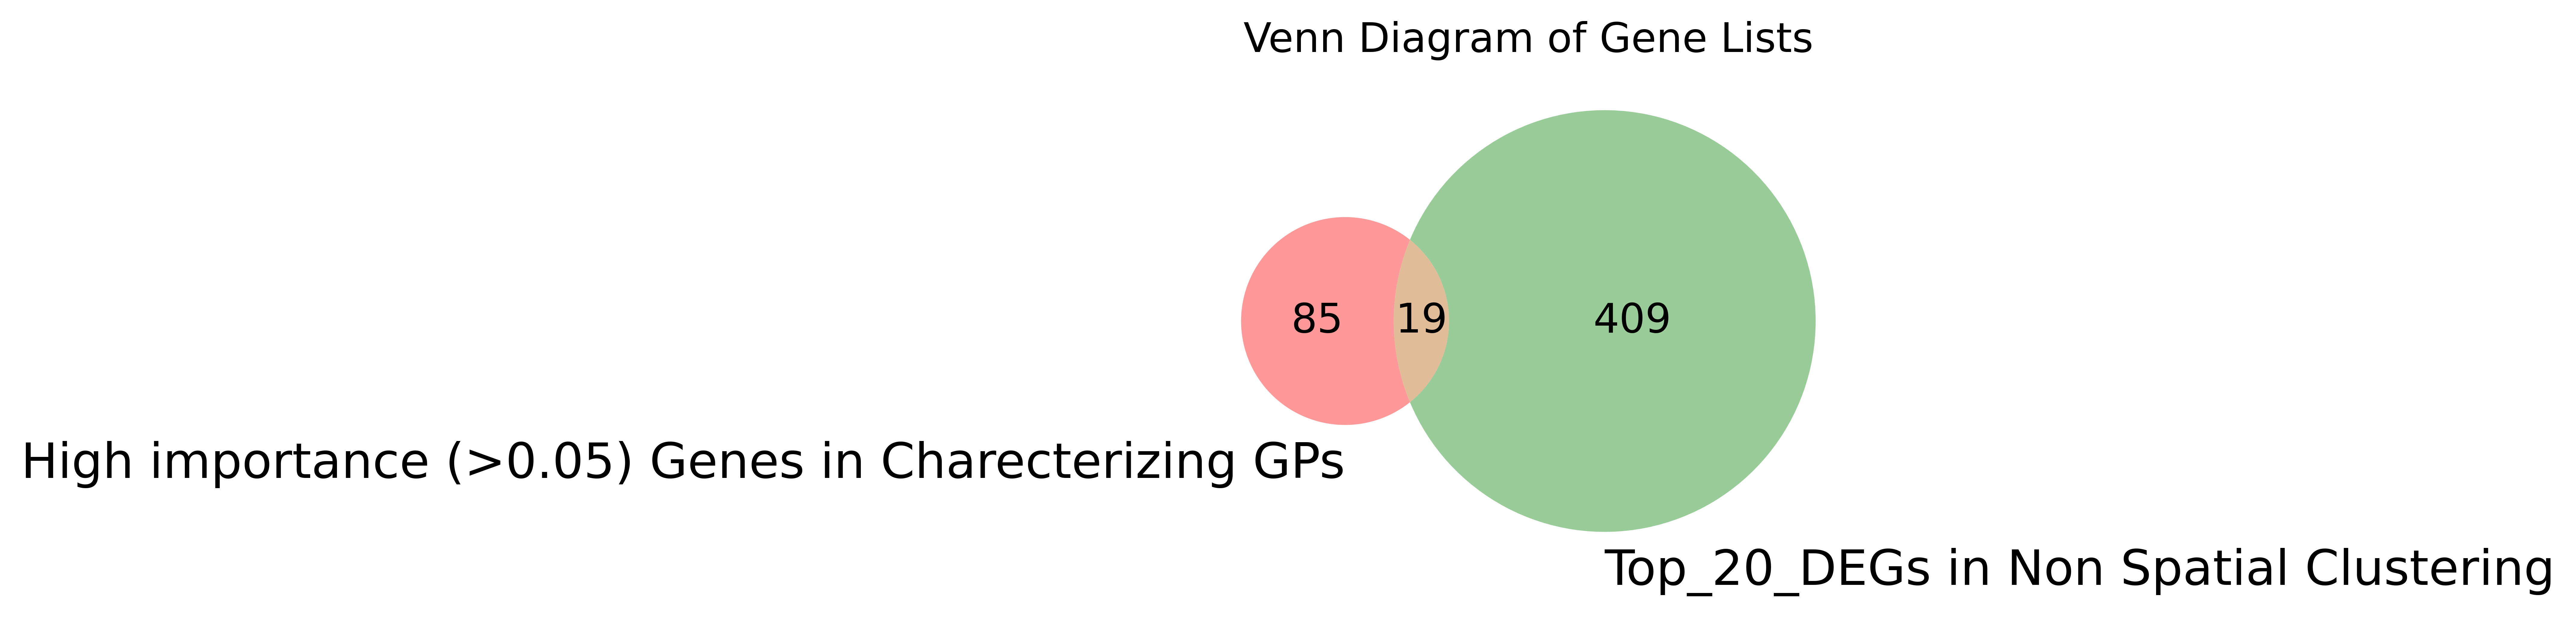

In [75]:
import matplotlib.pyplot as plt
from matplotlib_venn import venn2
venn2([set1, set2], ('High importance (>0.05) Genes in Charecterizing GPs', 'Top_20_DEGs in Non Spatial Clustering'))

plt.title('Venn Diagram of Gene Lists')
# plt.show()
plt.savefig('./overlap_20_degs_importance.svg', format='svg', bbox_inches='tight')

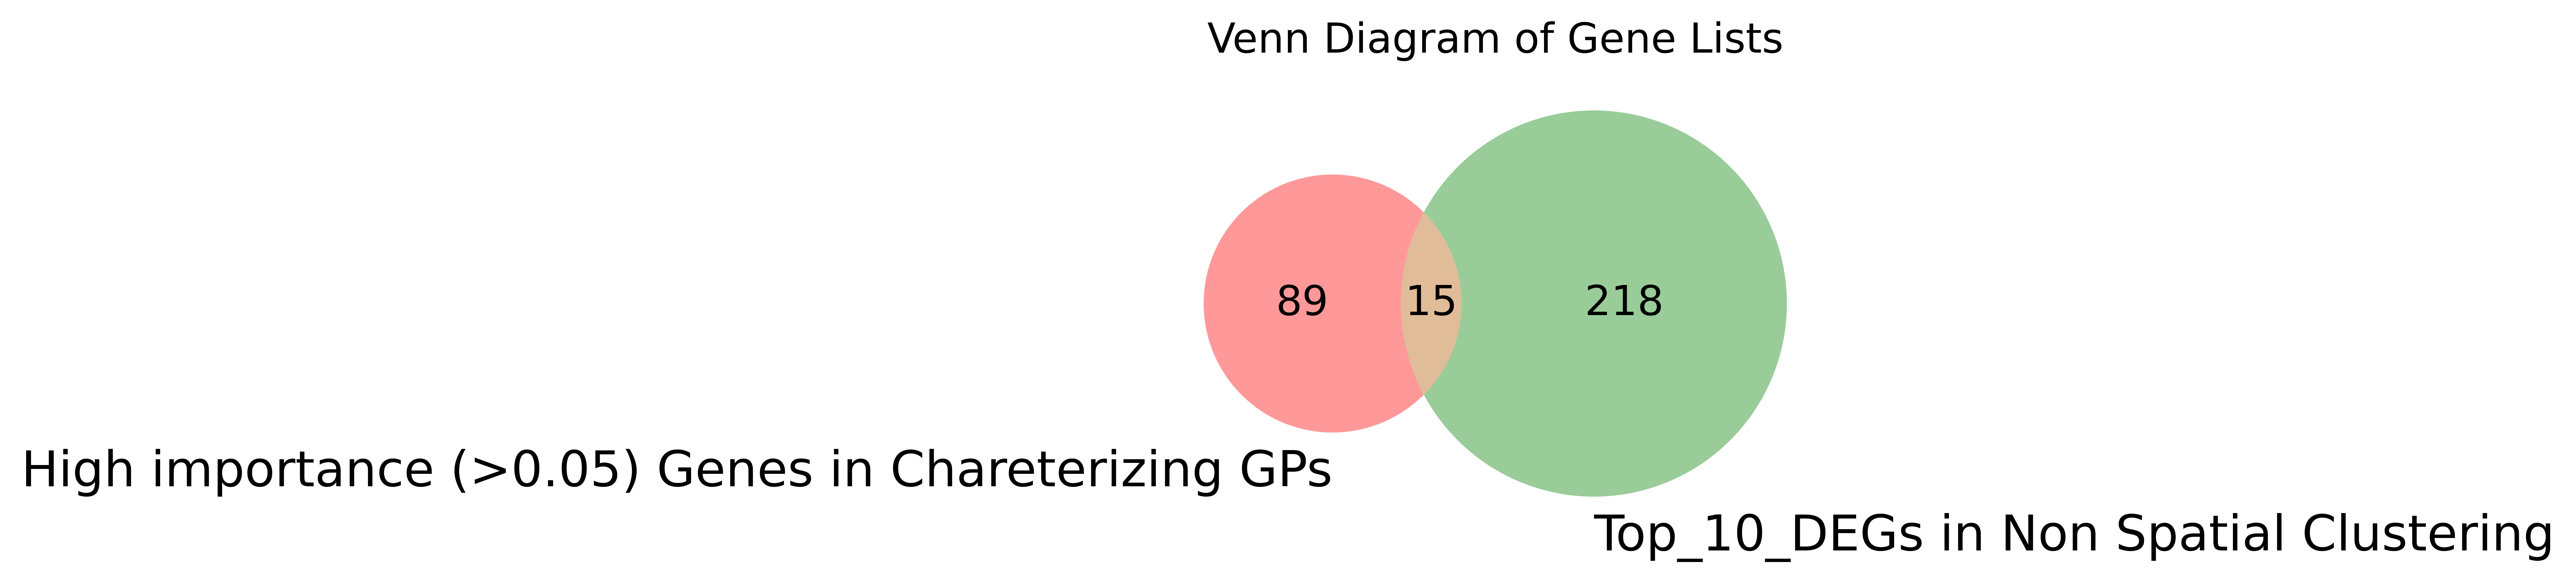

In [76]:
import matplotlib.pyplot as plt
from matplotlib_venn import venn2
venn2([set1, set4], ('High importance (>0.05) Genes in Chareterizing GPs', 'Top_10_DEGs in Non Spatial Clustering'))

plt.title('Venn Diagram of Gene Lists')
# plt.show()
plt.savefig('./overlap_10_degs_importance.svg', format='svg', bbox_inches='tight')

In [77]:
import numpy as np

# Assuming 'adata' is your AnnData object
all_genes = list(adata.var_names)  # List of all genes in adata.var_names


# Intersection of set1 and set2
set_intersection = set1.intersection(set2)

# Number of random selections and number of genes to select each time
n_selections = 10
n_genes_to_select = 428

# Lists to store the overlap results
overlap_set1 = []
overlap_set2 = []
overlap_intersection = []

# Perform the random selections and calculate overlaps
for _ in range(n_selections):
    # Randomly select 422 genes
    random_genes = set(np.random.choice(all_genes, n_genes_to_select, replace=False))
    
    # Calculate the intersection with set1, set2, and the intersection of set1 and set2
    overlap_with_set1 = len(random_genes.intersection(set1))
    overlap_with_set2 = len(random_genes.intersection(set2))
    overlap_with_intersection = len(random_genes.intersection(set_intersection))
    
    # Store the results
    overlap_set1.append(overlap_with_set1)
    overlap_set2.append(overlap_with_set2)
    overlap_intersection.append(overlap_with_intersection)

# Calculate the mean overlap for set1, set2, and their intersection
mean_overlap_set1 = np.mean(overlap_set1)
mean_overlap_set2 = np.mean(overlap_set2)
mean_overlap_intersection = np.mean(overlap_intersection)

# Print the mean overlaps
print(f"Mean overlap with set1: {mean_overlap_set1}")
print(f"Mean overlap with set2: {mean_overlap_set2}")
print(f"Mean overlap with the intersection of set1 and set2: {mean_overlap_intersection}")

Mean overlap with set1: 9.0
Mean overlap with set2: 37.0
Mean overlap with the intersection of set1 and set2: 2.0


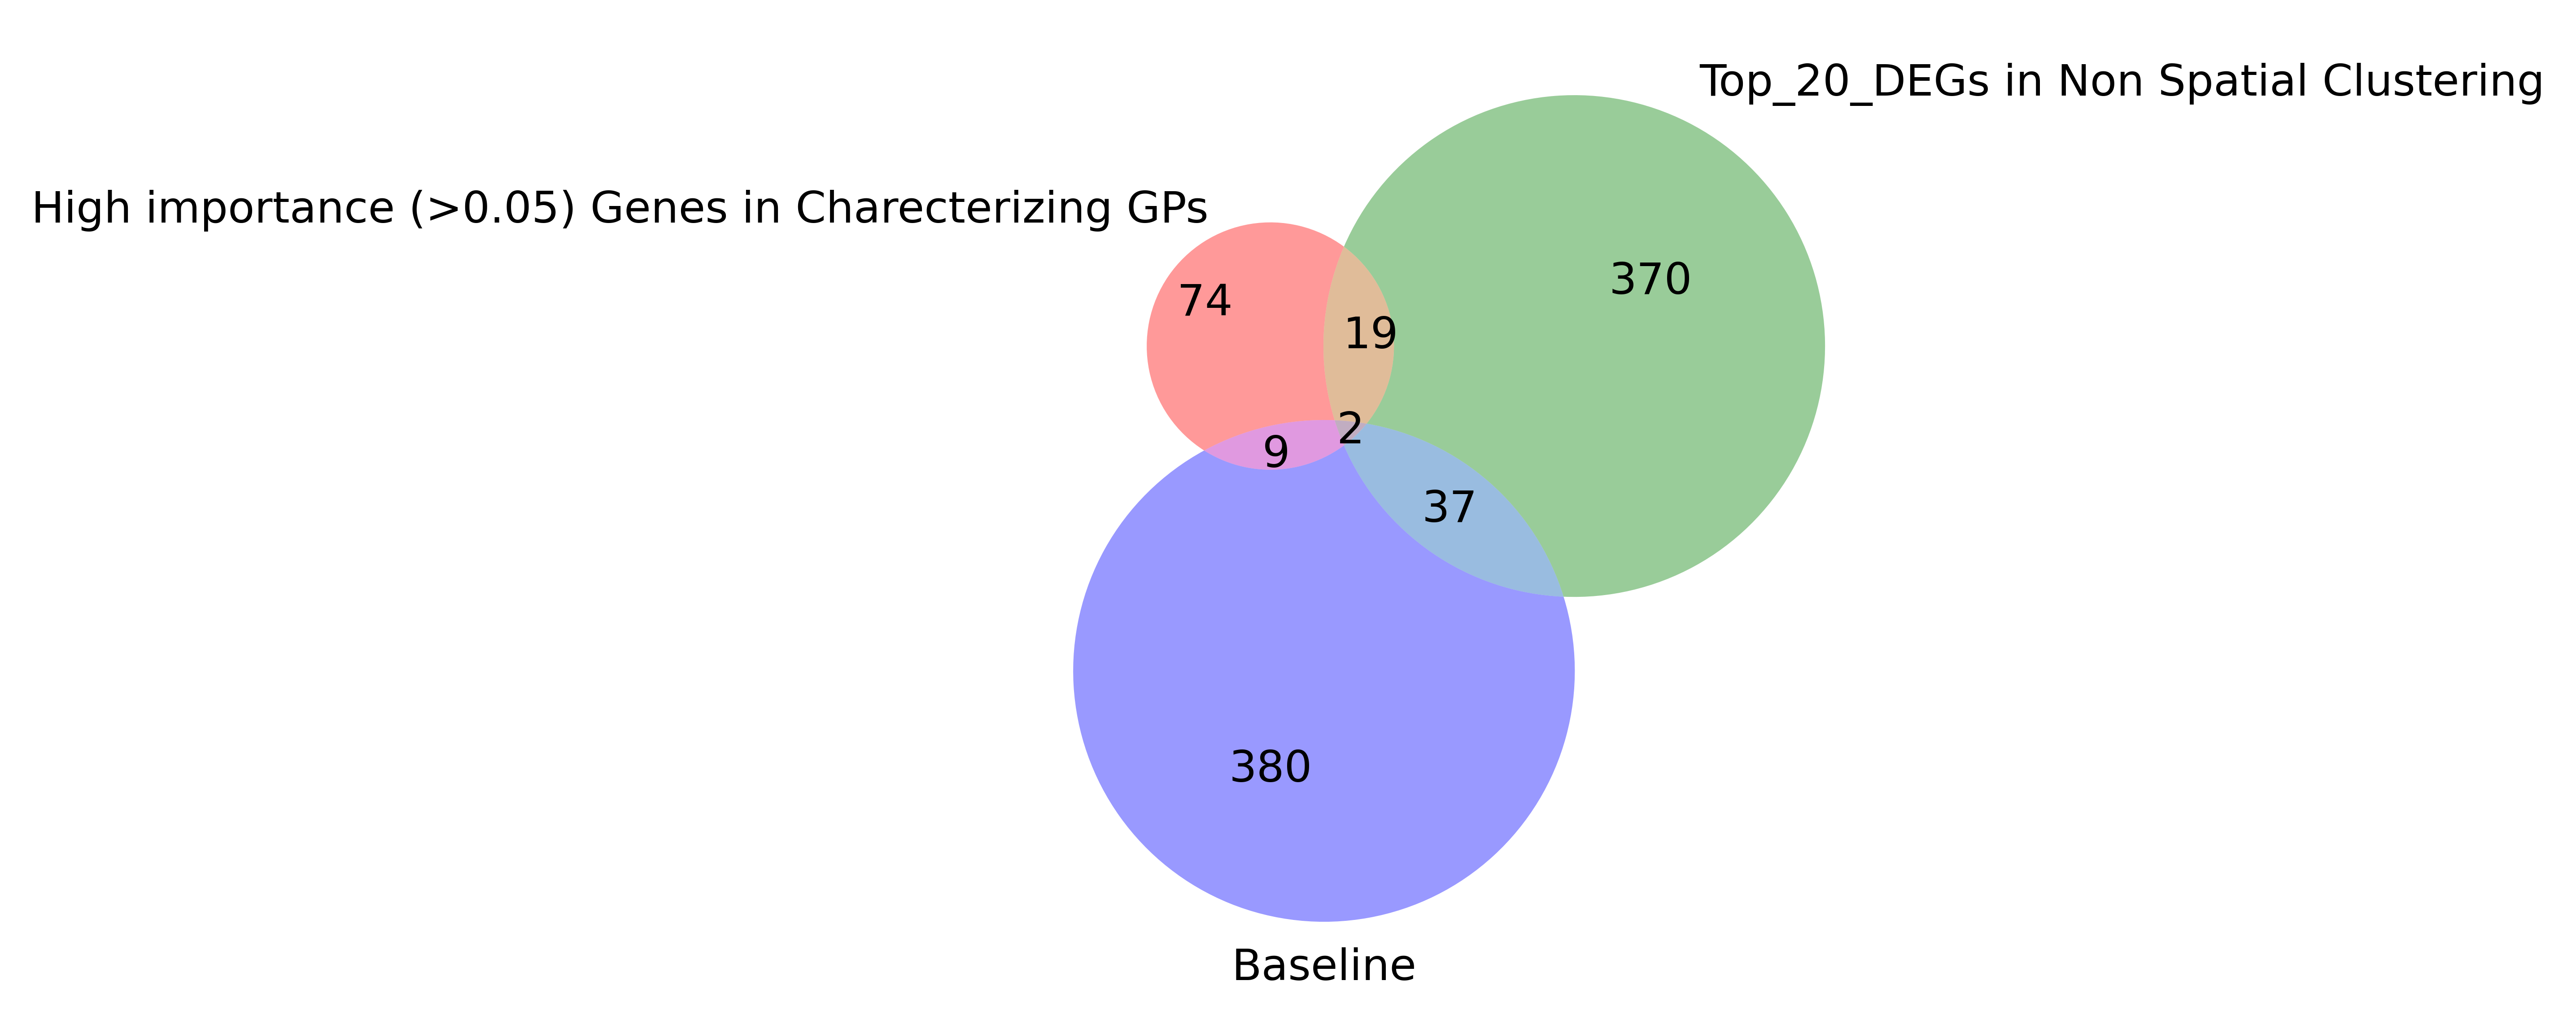

In [79]:
import matplotlib.pyplot as plt
from matplotlib_venn import venn3
from matplotlib import font_manager

# Set sizes
len_set1 = 74
len_set2 = 370
len_set3 = 380

# Overlaps
overlap_12 = 19    # Overlap between set1 and set2
overlap_13 = 9  # Overlap between set1 and set3
overlap_23 = 37  # Overlap between set2 and set3
overlap_123 = 2  # Overlap between all three sets

# Create the Venn diagram
venn=venn3(subsets=(len_set1, len_set2, overlap_12, len_set3, overlap_13, overlap_23, overlap_123),
      set_labels=('High importance (>0.05) Genes in Charecterizing GPs', 'Top_20_DEGs in Non Spatial Clustering', 'Baseline'))

# Adjust font properties for labels
font_properties = font_manager.FontProperties(size=10)  # Adjust size as needed

# Apply font properties to set labels
for label in venn.set_labels:
    label.set_fontproperties(font_properties)

# Apply font properties to subset labels
for label in venn.subset_labels:
    label.set_fontproperties(font_properties)

# Display the plot
# plt.show()
plt.savefig('./overlap_20_degs_baselines_importance_chareterizing_gps.svg', format='svg', bbox_inches='tight')

In [81]:
import numpy as np

# Assuming 'adata' is your AnnData object
all_genes = list(adata.var_names)  # List of all genes in adata.var_names


# Intersection of set1 and set2
set_intersection = set1.intersection(set2)

# Number of random selections and number of genes to select each time
n_selections = 10
n_genes_to_select = 233

# Lists to store the overlap results
overlap_set1 = []
overlap_set4 = []
overlap_intersection = []

# Perform the random selections and calculate overlaps
for _ in range(n_selections):
    # Randomly select 422 genes
    random_genes = set(np.random.choice(all_genes, n_genes_to_select, replace=False))
    
    # Calculate the intersection with set1, set2, and the intersection of set1 and set2
    overlap_with_set1 = len(random_genes.intersection(set1))
    overlap_with_set4 = len(random_genes.intersection(set4))
    overlap_with_intersection = len(random_genes.intersection(set_intersection))
    
    # Store the results
    overlap_set1.append(overlap_with_set1)
    overlap_set4.append(overlap_with_set4)
    overlap_intersection.append(overlap_with_intersection)

# Calculate the mean overlap for set1, set2, and their intersection
mean_overlap_set1 = np.mean(overlap_set1)
mean_overlap_set4 = np.mean(overlap_set4)
mean_overlap_intersection = np.mean(overlap_intersection)

# Print the mean overlaps
print(f"Mean overlap with set1: {mean_overlap_set1}")
print(f"Mean overlap with set4: {mean_overlap_set4}")
print(f"Mean overlap with the intersection of set1 and set4: {mean_overlap_intersection}")

Mean overlap with set1: 5.8
Mean overlap with set4: 10.2
Mean overlap with the intersection of set1 and set4: 1.3


In [ ]:
import matplotlib.pyplot as plt
from matplotlib_venn import venn3
from matplotlib import font_manager

# Set sizes
len_set1 = 81.9
len_set4 = 206.5
len_set3 = 215.7

# Overlaps
overlap_14 = 15    # Overlap between set1 and set2
overlap_13 = 5.8  # Overlap between set1 and set3
overlap_43 = 10.2  # Overlap between set2 and set3
overlap_143 = 1.3  # Overlap between all three sets

# Create the Venn diagram
venn=venn3(subsets=(len_set1, len_set4, overlap_14, len_set3, overlap_13, overlap_43, overlap_143),
      set_labels=('High importance (>0.05) Genes in Charecterizing GPs', 'Top_20_DEGs in Non Spatial Clustering', 'Baseline'))

# Adjust font properties for labels
font_properties = font_manager.FontProperties(size=10)  # Adjust size as needed

# Apply font properties to set labels
for label in venn.set_labels:
    label.set_fontproperties(font_properties)

# Apply font properties to subset labels
for label in venn.subset_labels:
    label.set_fontproperties(font_properties)

# Display the plot
# plt.show()
plt.savefig('./overlap_10_degs_baselines_importance_chareterizing_gps.svg', format='svg', bbox_inches='tight')